In [1]:
import pandas as pd
import warnings 
import numpy as np

warnings.filterwarnings('ignore')

df = pd.read_csv('../price.csv',index_col=['stock_id','date'],parse_dates=['date'])
df = df.rename(columns={
    '開盤價':'open',
    '最高價':'high',
    '最低價':'low',
    '收盤價':'close',
    '成交金額':'volume'
})
df = df[['open','high','low','close','volume']]
df = df.loc[df['volume']>0]
df = df.apply(pd.to_numeric,errors='coerce')
df = df.loc['2330']
df

,open,high,low,close,volume
date,,,,,
2007-01-02,67.8,68.0,67.3,67.7,1768131919
2007-01-03,67.8,68.7,67.5,68.0,2875024398
2007-01-04,67.7,68.1,67.6,67.7,1514454033
2007-01-05,67.5,67.7,66.5,66.9,2048997239
2007-01-08,66.1,66.5,65.7,65.8,1595029837
...,...,...,...,...,...
2024-11-04,1030.0,1045.0,1025.0,1040.0,29263376605
2024-11-05,1030.0,1055.0,1030.0,1050.0,34851674542
2024-11-06,1050.0,1080.0,1040.0,1060.0,63110184620


<AxesSubplot:>

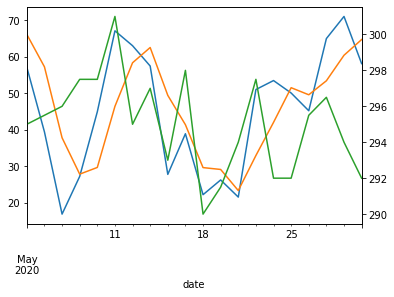

In [11]:
import talib
import talib.abstract as abstract

# talib.get_functions()
abstract.STOCH(df)['2020-05']['slowk'].plot()
abstract.STOCH(df)['2020-05']['slowd'].plot()
df['close']['2020-05'].plot(secondary_y=True)

In [13]:
abstract.STOCH(df)

,slowk,slowd
date,,
2007-01-02,NaN,NaN
2007-01-03,NaN,NaN
2007-01-04,NaN,NaN
2007-01-05,NaN,NaN
2007-01-08,NaN,NaN
...,...,...
2022-06-20,9.377289,8.115802
2022-06-21,23.968254,13.288563
2022-06-22,20.634921,17.993488


2 6 17 60 12.0
2 6 17 70 15.0
2 6 17 86 495.0
4 6 25 88 496.0
4 11 39 71 496.79999999999995


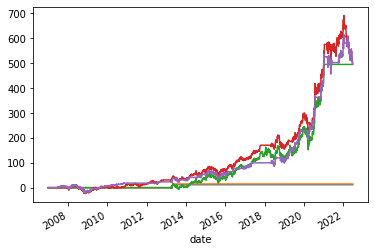

In [16]:
highest_earning = 0 

for fastkd in range(2,5,1):
    for slowkd in range(6,12,1):

        kd = abstract.STOCH(df,fastk_period=fastkd,slowk_period=slowkd,slowd_period=slowkd)

        df['k'] = kd['slowk']
        df['d'] = kd['slowd']
        
        for lowKD in range(14,40,1):
            for highKD in range(60,90,1):

                df['hold'] = np.nan
                df.loc[(df['k'].shift(1)<df['d'].shift(1))&(df['k']>df['d'])&(df['d']<lowKD),'hold'] = 1
                df.loc[(df['k'].shift(1)>df['d'].shift(1))&(df['k']<df['d'])&(df['d']>highKD),'hold'] = 0

                df['hold'].ffill(inplace=True)
                df['hold'] = df['hold'].fillna(0)

                df['earn'] = 0
                df['earn'].loc[df['hold']==1] = df['open'].shift(-2)-df['open'].shift(-1)

               
                
                if df['earn'].cumsum().dropna().iloc[-1]>highest_earning:
                    print(fastkd,slowkd,lowKD,highKD,df['earn'].cumsum().dropna().iloc[-1])
                    df['earn'].cumsum().plot()
                    highest_earning = df['earn'].cumsum().dropna().iloc[-1]

4 11 39 89 495.0


Start date,2007-01-02
End date,2022-06-24
Total months,181
,Backtest
Annual return,12.509%
Cumulative returns,495.0%
Annual volatility,17.468%
Sharpe ratio,0.76
Calmar ratio,0.46
Stability,0.82
Max drawdown,-27.062%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.06,2020-01-10,2020-03-17,2020-07-07,128
1,23.38,2015-03-19,2015-08-21,2016-03-09,255
2,21.08,2018-09-04,2019-01-02,2019-04-17,162
3,19.83,2013-05-07,2013-08-19,2014-03-11,221
4,19.77,2018-01-22,2018-06-26,2018-08-28,157


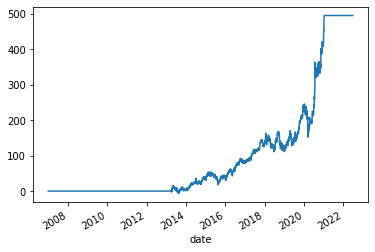

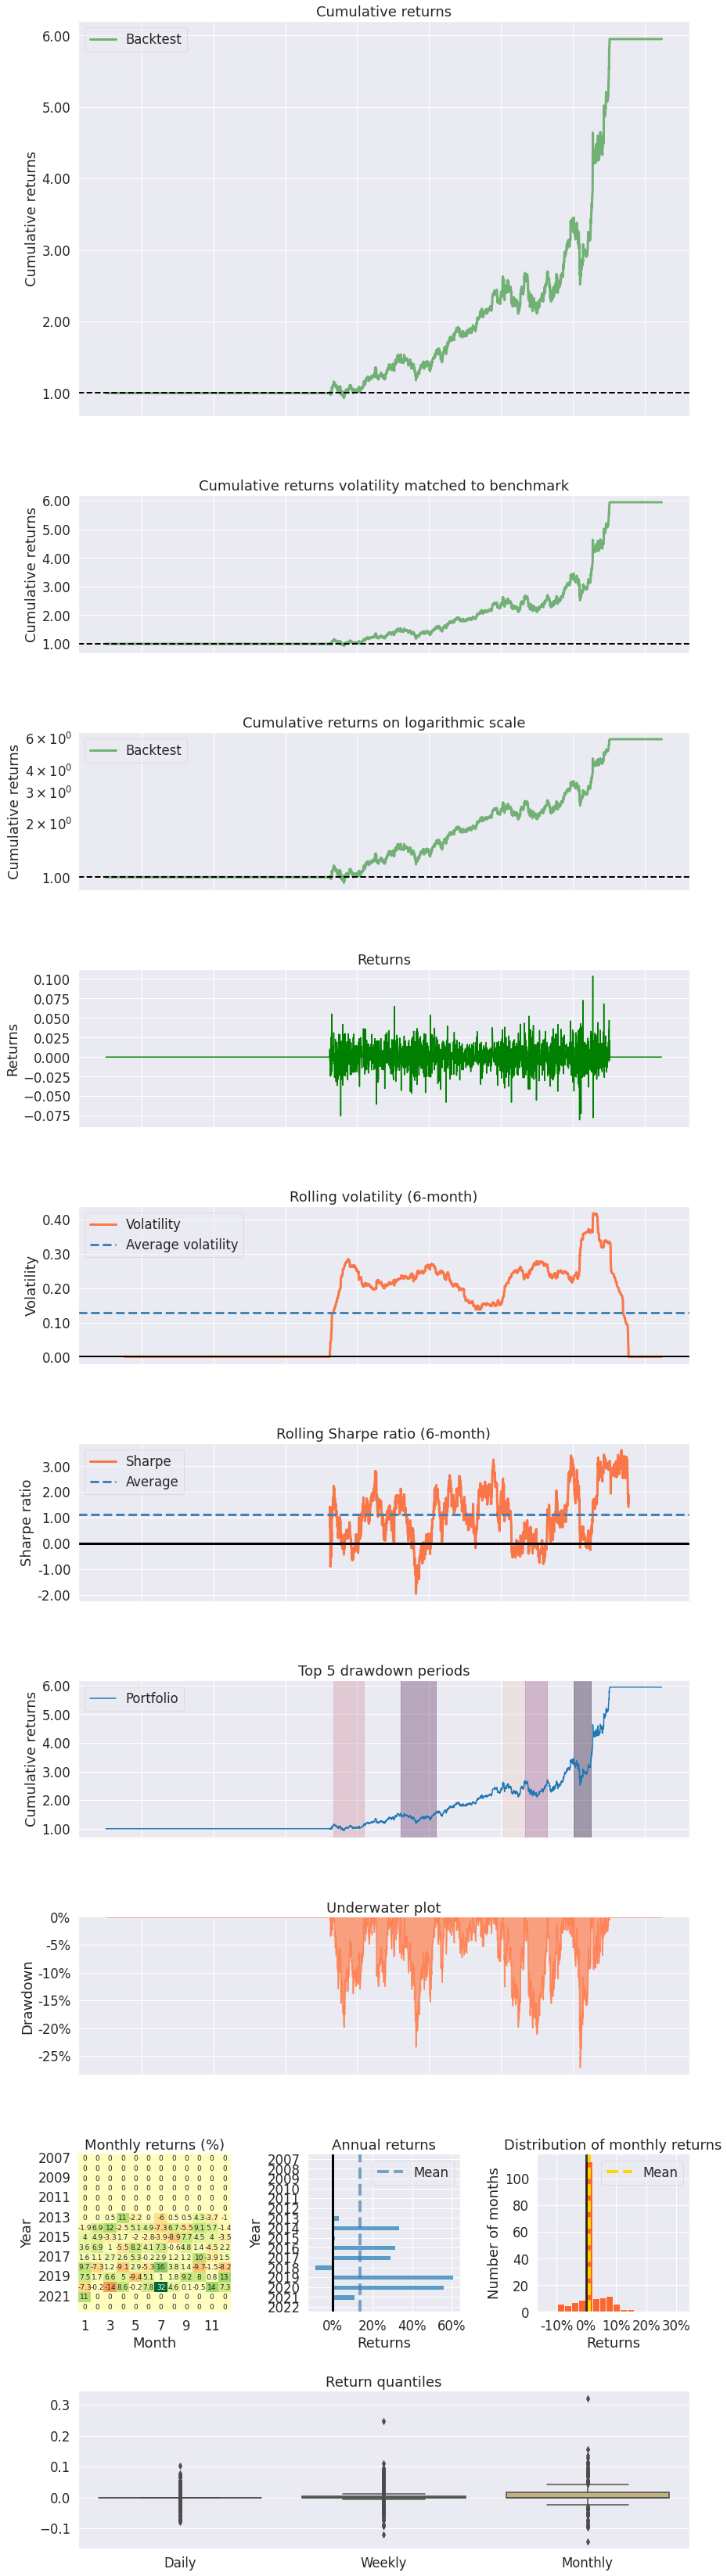

In [18]:
kd = abstract.STOCH(df,fastk_period=2,slowk_period=6,slowd_period=6)

df['k'] = kd['slowk']
df['d'] = kd['slowd']


df['hold'] = np.nan
df.loc[(df['k'].shift(1)<df['d'].shift(1))&(df['k']>df['d'])&(df['d']<17),'hold'] = 1
df.loc[(df['k'].shift(1)>df['d'].shift(1))&(df['k']<df['d'])&(df['d']>86),'hold'] = 0

df['hold'].ffill(inplace=True)
df['hold'] = df['hold'].fillna(0)

df['earn'] = 0
df['earn'].loc[df['hold']==1] = df['open'].shift(-2)-df['open'].shift(-1)

print(fastkd,slowkd,lowKD,highKD,df['earn'].cumsum().dropna().iloc[-1])
df['earn'].cumsum().plot()

import pyfolio as pf

pf.create_returns_tear_sheet((df['earn']/df['open'].shift(-1)))